# Function Optimization with Genetic Algorithms

This notebook is an introduction to Genetic Algorithms to minimize a real-valued function.

In [13]:
## Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Union, Callable

RNG = np.random.RandomState(1234)

We can minimize/maximize a function with genetic algorithms! In order to do so, we need to follow these steps:

1. Generate a population of candidate solutions (randomly)
2. Repeat until satisfied
    1. Test the quality of the candidate solutions
    2. Select solutions to reproduce
    3. Produce new variations of selected solutions
    4. Replace old solutions with new ones


To illustrate this procedure, let's start with a very simple example. Consider the following function

$$f(x) = (x - a)^2$$

Let's define the function and see the plot

In [14]:
# This is the function that we want to minimize
def objective_function(x: np.ndarray, a: float = 7.0) -> np.ndarray:
    return (x - a) ** 2

We can see that the minimum of $f(x)$ is $a$. From elementary calculus, we know that $\arg \min_{x} f(x)$ is the solution of $\frac{d f(x)}{dx} = 0$

$$\frac{d f(x)}{dx} = 2(x - a)$$

$$2(x - a) = 0 \Rightarrow x =  a$$

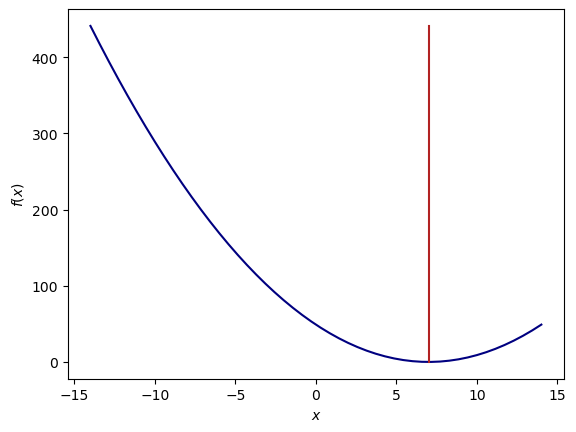

In [15]:
a = 7
x = np.linspace(-2 * a, 2 * a)
y = objective_function(x, a)
plt.plot(x, y, c="navy")

plt.plot(
    np.ones_like(x) * a,
    np.linspace(y.min(), y.max(), len(x)),
    c="firebrick",
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.show()

## Genetic Algorithm

### Generating a population of solutions 

The first step for solving the problem is to generate a population of solutions. A common way to do this is to simply sample candidate solutions.

In [16]:
# Generate Initial Population
def initialize_population(pop_size: int, bounds: Tuple[int]) -> np.ndarray:
    """
    Initialize population drawing samples from a uniform distribution

    Parameters
    ----------
    pop_size : int
        Size of the population
    bounds: Tuple[int]
        Lower and Upper bounds for the uniform distribution

    Returns
    np.ndarray
        Initial population
    """
    return RNG.uniform(bounds[0], bounds[1], pop_size)

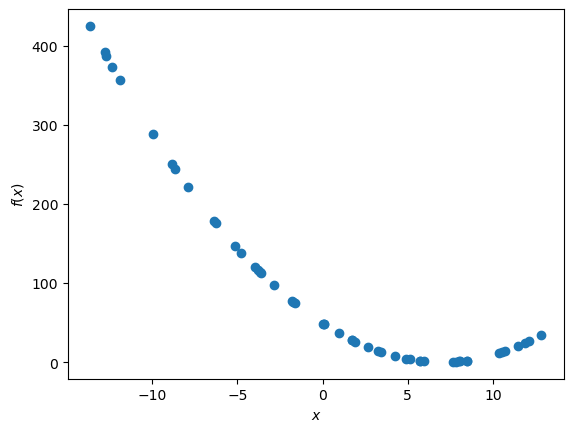

In [17]:
population = initialize_population(50, (-2*a, 2*a))

plt.scatter(population, objective_function(population))
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.show()

### Testing the quality of the solutions: Fitness function

To evaluate the quality of the solutions (i.e., how well do they solve the problem), we define a simple fitness function that let us know how well the solutions minimize/maximize the problem

Note that there are many possibilities here!

In [18]:
# Fitness Evaluation
def fitness_function(
    x: np.ndarray,
    objective_function: Callable[[np.ndarray], np.ndarray] = objective_function,
) -> np.ndarray:
    """Fitness function

    Parameters
    ----------
    x : np.ndarray
        Input samples
    
    objective_function: Callable[[np.ndarray], np.ndarray]
        Function that we want to optimize.

    Returns
    -------
    np.ndarray
        Fitness function. Higher fitness for lower objective value
    """
    return 1 / (1 + abs(objective_function(x)))

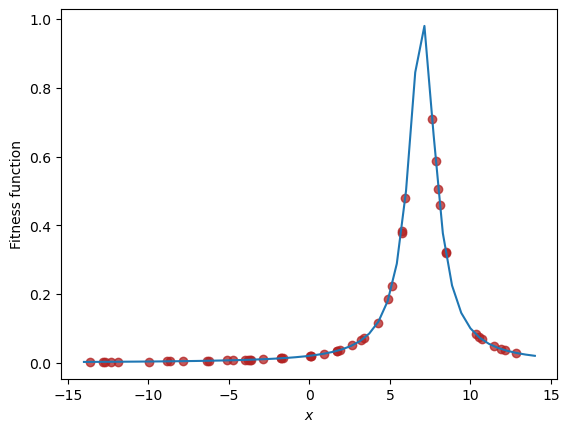

In [19]:
plt.plot(x, fitness_function(x))
plt.scatter(
    population,
    fitness_function(population),
    c="firebrick",
    alpha=0.75,
)
plt.xlabel("$x$")
plt.ylabel("Fitness function")
plt.show()

### Selecting solutions to reproduce

There are several strategies to select solutions

1. **Double Tournament Selection**:
   - A group of $n$ solutions is randomly chosen, and the fittest one is selected as a parent.
   - The process is repeated with a new group for the second parent.
   - It can be done with or without replacement (allowing or disallowing the same parent to be picked twice).

2. **Roulette Wheel Selection**:
   - Parents are chosen with probabilities proportional to their fitness.
   - A solutions's probability of selection is  $f_i/F$, where $f_i$ is its fitness and $F$ is the sum of fitness values in the population.

3. **Rank Selection**:
   - Similar to roulette selection but based on rank rather than raw fitness.
   - Creatures are ranked by fitness, and probabilities are based on their rank values.
   - The least fit creature has rank 1, giving it the lowest chance of being selected.

   In here we implement the Roulette wheel selection

In [20]:
# Softmax Function
def softmax(x: np.ndarray) -> np.ndarray:
    output = np.exp(x - np.max(x))  # Stability trick to avoid overflow
    return output / np.sum(output)


# Selection (Roulette Wheel)
def selection(pop: np.ndarray, fitness: np.ndarray) -> np.ndarray:

    # We can use softmax instead of just 
    # the scaled fitness to ensure a normalized probability
    # distribution
    # prob = fitness / np.sum(fitness)
    prob = softmax(fitness)
    
    chosen_idx = RNG.choice(len(pop), size=len(pop), p=prob)
    return pop[chosen_idx]


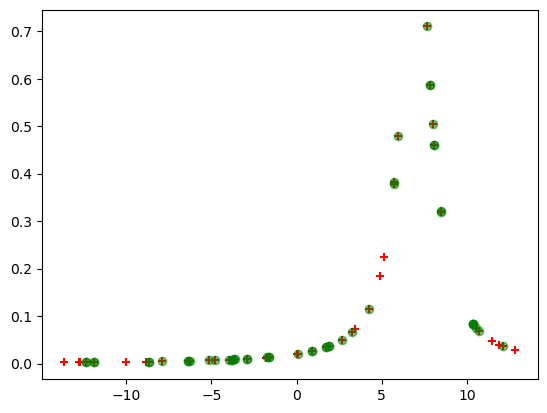

In [21]:
selected_solutions = selection(population, fitness_function(population))

plt.scatter(
    population,
    fitness_function(population),
    c="red",
    marker="+",
)
plt.scatter(
    selected_solutions,
    fitness_function(selected_solutions),
    c="green",
    marker="o",
    alpha=0.5,
)
plt.show()

### Producing variations: Crossover and Mutation

In [22]:
# Crossover
def crossover(parent1, parent2, crossover_rate=0.7):
    if RNG.rand() < crossover_rate:
        alpha = RNG.rand()  # Blend factor
        child1 = alpha * parent1 + (1 - alpha) * parent2
        child2 = alpha * parent2 + (1 - alpha) * parent1
        return child1, child2
    return parent1, parent2


# Mutation
def mutate(child, mutation_rate=0.1, bounds=(-10, 10)):
    if RNG.rand() < mutation_rate:
        mutation = RNG.uniform(bounds[0], bounds[1])
        child += mutation
    return child



### Putting it all together

Let's put everything together into a single function.

In [23]:
# Updated Genetic Algorithm
def genetic_algorithm(bounds, pop_size=500, generations=1000):
    # Step 1: Initialize population
    population = initialize_population(pop_size, bounds)
    best_solutions = []

    # Step 2: Repeat
    for gen in range(generations):
        # Step 2.1 Test quality of solutions
        fitness = np.array([fitness_function(x) for x in population])
        best_solutions.append(population[np.argmax(fitness)])

        # Step 2.2 Selection
        selected_pop = selection(population, fitness)

        # Step 2.3 Create Next Generation
        next_gen = []
        for i in range(0, len(selected_pop), 2):
            parent1 = selected_pop[i]
            parent2 = selected_pop[min(i + 1, len(selected_pop) - 1)]
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, bounds=bounds)
            child2 = mutate(child2, bounds=bounds)
            next_gen.extend([child1, child2])

        population = np.clip(next_gen, bounds[0], bounds[1])

    return population, best_solutions


Let's test the code!

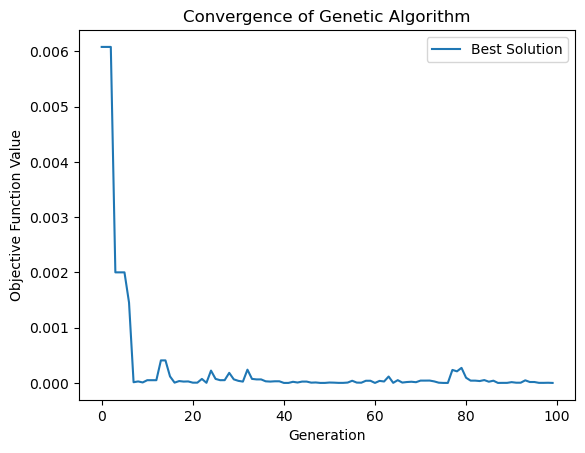

Best solution found: 6.9618617393435365
Function value at best solution: 9.32309048368549e-08


In [24]:
# Run the Algorithm
bounds = (-10, 10)
pop_size = 50
generations = 100

final_population, best_solutions = genetic_algorithm(bounds, pop_size, generations)

# Plot Results
generations = np.arange(len(best_solutions))
best_fitness = [objective_function(x) for x in best_solutions]

plt.plot(generations, best_fitness, label="Best Solution")
plt.title("Convergence of Genetic Algorithm")
plt.xlabel("Generation")
plt.ylabel("Objective Function Value")
plt.legend()
plt.show()

print("Best solution found:", min(best_solutions))
print("Function value at best solution:", min(best_fitness))